# Time Series Practice

## Importing


In [1]:
from astropy.utils.data import get_pkg_data_filename
filename = get_pkg_data_filename('timeseries/kplr010666592-2009131110544_slc.fits')  

In [2]:
from astropy.timeseries import TimeSeries
from astropy.timeseries import BoxLeastSquares

In [3]:
ts = TimeSeries.read(filename, format='kepler.fits')

In [4]:
print(ts)

          time             timecorr   ...   pos_corr1      pos_corr2   
                              d       ...      pix            pix      
----------------------- ------------- ... -------------- --------------
2009-05-02T00:41:40.338  6.630610e-04 ...  1.5822421e-03 -1.4463664e-03
2009-05-02T00:42:39.188  6.630857e-04 ...  1.5743829e-03 -1.4540013e-03
2009-05-02T00:43:38.045  6.631103e-04 ...  1.5665225e-03 -1.4616371e-03
2009-05-02T00:44:36.894  6.631350e-04 ...  1.5586632e-03 -1.4692718e-03
2009-05-02T00:45:35.752  6.631597e-04 ...  1.5508028e-03 -1.4769078e-03
2009-05-02T00:46:34.601  6.631844e-04 ...  1.5429436e-03 -1.4845425e-03
                    ...           ... ...            ...            ...
2009-05-11T18:01:19.065  1.014567e-03 ...  3.6063993e-03  3.1717657e-03
2009-05-11T18:02:17.923  1.014591e-03 ...  3.6044715e-03  3.1640085e-03
2009-05-11T18:03:16.772  1.014615e-03 ...  3.6025438e-03  3.1562524e-03
2009-05-11T18:04:15.630  1.014640e-03 ...  3.6006160e-03  3.1484

In [5]:
print(ts['cadenceno'])

cadenceno 
----------
      5500
      5501
      5502
      5503
      5504
      5505
      5506
       ...
     19773
     19774
     19775
     19776
     19777
     19778
     19779
Length = 14280 rows


In [6]:
print(ts['time', 'sap_flux'])

          time             sap_flux   
                         electron / s 
----------------------- --------------
2009-05-02T00:41:40.338  1.0270451e+06
2009-05-02T00:42:39.188  1.0271844e+06
2009-05-02T00:43:38.045  1.0270762e+06
2009-05-02T00:44:36.894  1.0271414e+06
2009-05-02T00:45:35.752  1.0271569e+06
2009-05-02T00:46:34.601  1.0272296e+06
                    ...            ...
2009-05-11T18:01:19.065  1.0243234e+06
2009-05-11T18:02:17.923  1.0244257e+06
2009-05-11T18:03:16.772  1.0248654e+06
2009-05-11T18:04:15.630  1.0250156e+06
2009-05-11T18:05:14.479  1.0254516e+06
2009-05-11T18:06:13.328  1.0254685e+06
2009-05-11T18:07:12.186  1.0259309e+06
Length = 14280 rows


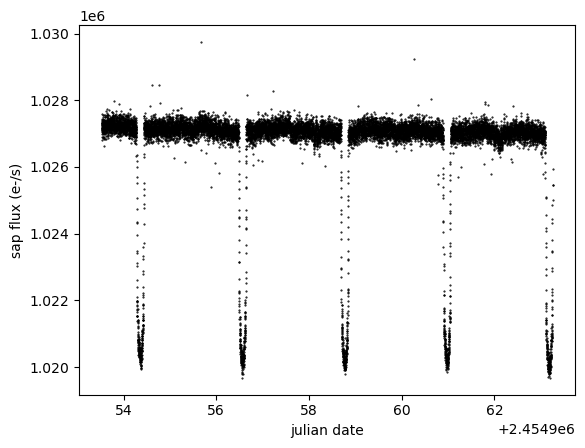

In [7]:
import matplotlib.pyplot as plt
plt.plot(ts.time.jd, ts['sap_flux'], 'k.', markersize=1)
plt.xlabel('julian date')
plt.ylabel('sap flux (e-/s)')
plt.show()

In [36]:
import numpy as np
from astropy import units as u
from astropy.timeseries import BoxLeastSquares

periodogram = BoxLeastSquares.from_timeseries(ts, 'sap_flux')

In [37]:
results = periodogram.autopower(0.2 * u.day, objective='snr')
best = np.argmax(results.power)
period = results.period[best]
print(period)

<Quantity 2.21584977 d>

In [38]:
print(results)

          depth: <Quantity [ 107.67232547,  181.35317717,  179.86374907, ..., 2042.31941569,
           2045.67364221, 2038.80486171] electron / s>
      depth_err: <Quantity [0.01675952, 0.01675982, 0.01675956, ..., 0.0425357 , 0.04260662,
           0.04257111] electron / s>
      depth_snr: <Quantity [ 6424.54818921, 10820.71423402, 10732.00937448, ...,
           48014.2473289 , 48013.04943312, 47891.74808063]>
       duration: <Quantity [0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2] d>
 log_likelihood: <Quantity [4.16432402e+07, 1.18350976e+08, 1.16237029e+08, ...,
           1.20126776e+09, 1.20103205e+09, 1.19505851e+09] electron2 / s2>
      objective: 'snr'
         period: <Quantity [0.4       , 0.40033857, 0.40067771, ..., 4.75579216, 4.80409697,
           4.85339313] d>
          power: <Quantity [ 6424.54818921, 10820.71423402, 10732.00937448, ...,
           48014.2473289 , 48013.04943312, 47891.74808063]>
   transit_time: <Time object: scale='tdb' format='isot' value=['2009-05-02T

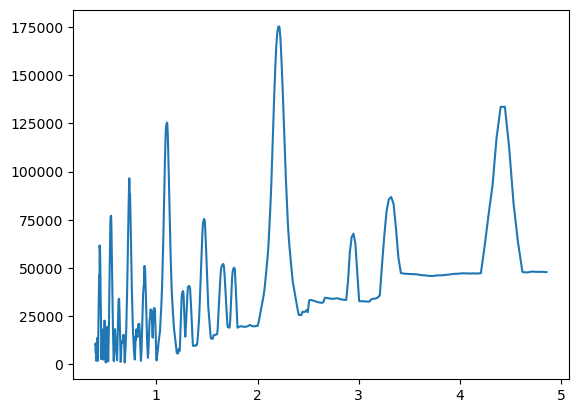

In [39]:
plt.plot(results.period, results.power)
plt.show()

In [40]:
transit_time = results.transit_time[best]
print(transit_time)

<Time object: scale='tdb' format='isot' value=2009-05-02T20:22:28.338>

In [41]:
print(transit_time.jd)

MaskedNDArray(2454954.3489391)

In [42]:
ts_folded = ts.fold(period=period, epoch_time=transit_time)

Text(0, 0.5, 'sap flux (e-/s)')

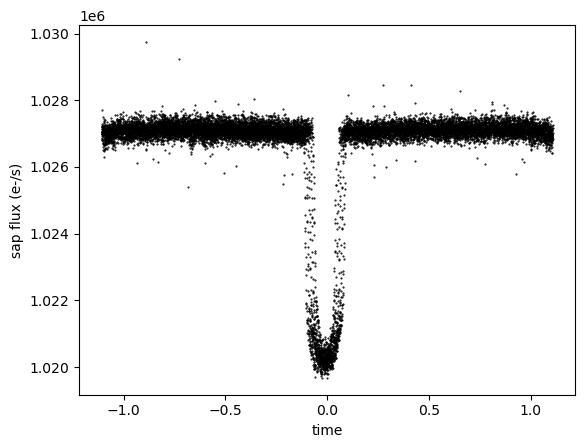

In [43]:
plt.plot(ts_folded.time.jd, ts_folded['sap_flux'], 'k.', markersize=1)
plt.xlabel('time')
plt.ylabel('sap flux (e-/s)')
plt.show()

In [44]:
from astropy.timeseries import aggregate_downsample
from astropy.stats import sigma_clipped_stats

In [45]:
mean, median, stddev = sigma_clipped_stats(ts_folded['sap_flux'])
ts_folded['sap_flux_norm'] = ts_folded['sap_flux'] / median
ts_binned = aggregate_downsample(ts_folded, time_bin_size=0.03 * u.day)
print(ts_binned)

/usr/lib/python3/dist-packages/astropy/timeseries/downsample.py:31: RuntimeWarning: Mean of empty slice
  result.append(function(array[indices[i] : indices[i + 1]]))
/usr/lib/python3/dist-packages/astropy/timeseries/downsample.py:32: RuntimeWarning: Mean of empty slice
  result.append(function(array[indices[-1] :]))


time_bin_start,time_bin_size,timecorr,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2,sap_flux_norm
,d,d,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix,
TimeDelta,float64,float64,int32,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-1.107789031828585,0.03,0.0008544125594198704,13259,1026988.9375,140.15797424316406,3746.4794921875,2.2322030067443848,1034737.5625,159.1085205078125,280,nan,nan,nan,nan,1041.557803026192,0.00013442612544167787,613.4820449022,0.00017142828437499702,0.0010152356699109077,0.000347466382663697,0.9998893141746521
-1.0777890318285852,0.03,0.0008548203622922301,13276,1027014.1875,140.14688110351562,3750.06103515625,2.2310280799865723,1034764.5625,156.83450317382812,285,nan,nan,nan,nan,1041.5577506005395,0.00013433961430564523,613.4821512086885,0.00017134039080701768,0.0009702237439341843,0.0004004763322882354,0.9999139308929443
-1.0477890318285852,0.03,0.0008561338181607425,13329,1027090.8125,140.14952087402344,3755.597412109375,2.2312769889831543,1034841.75,158.29718017578125,282,nan,nan,nan,nan,1041.5577255618114,0.00013432491687126458,613.4820333257228,0.00017132083303295076,0.0009066906059160829,0.00033554036053828895,0.9999886155128479
-1.0177890318285852,0.03,0.0008569933706894517,13364,1027100.1875,140.1514434814453,3737.3828125,2.2306222915649414,1034852.0,156.05445861816406,145,nan,nan,nan,nan,1041.5577133576446,0.00013432840933091938,613.4820978172057,0.00017133179062511772,0.0008587865740992129,0.0003501045284792781,0.9999976754188538
-0.9877890318285851,0.03,0.0008580766734667122,13408,1027070.9375,140.14756774902344,3725.661865234375,2.230750322341919,1034825.625,157.5037078857422,192,nan,nan,nan,nan,1041.5576265289455,0.0001343329786323011,613.4820895149188,0.00017132853099610656,0.0008398937643505633,0.0003670474688988179,0.9999691247940063
-0.9577890318285851,0.03,0.0008589372155256569,13443,1027123.6875,140.15045166015625,3743.528564453125,2.2322378158569336,1034877.8125,155.8478546142578,159,nan,nan,nan,nan,1041.5576607981745,0.00013432100240606815,613.4822082327147,0.00017131988715846092,0.0008287428063340485,0.0004282378067728132,1.0000206232070923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.9322109681714162,0.03,0.0008473770576529205,12974,1027145.25,140.16746520996094,3675.880615234375,2.230440378189087,1034891.0625,159.11199951171875,113,nan,nan,nan,nan,1041.5574559445902,0.00013443129137158394,613.4819425507043,0.00017143256263807416,0.0006612354191020131,0.00021146578365005553,1.0000416040420532


Text(0, 0.5, 'normalized flux')

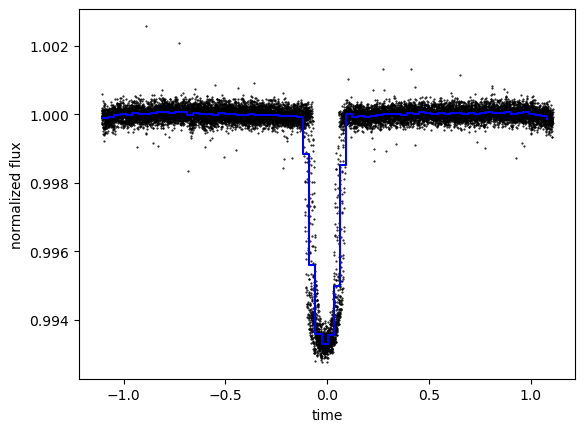

In [46]:
plt.plot(ts_folded.time.jd, ts_folded['sap_flux_norm'], 'k.', markersize=1)
plt.plot(ts_binned.time_bin_start.jd, ts_binned['sap_flux_norm'], 'b-', drawstyle='steps-post')
plt.xlabel('time')
plt.ylabel('normalized flux')
plt.show()

In [48]:
max_power = np.argmax(results.power)
stats = periodogram.compute_stats(results.period[max_power],
                                  results.duration[max_power],
                                  results.transit_time[max_power])

print(stats)
# compute the max point on the periodogram

{'transit_times': <Time object: scale='tdb' format='isot' value=['2009-05-02T20:22:28.338' '2009-05-05T01:33:17.759'
  '2009-05-07T06:44:07.179' '2009-05-09T11:54:56.599'
  '2009-05-11T17:05:46.020']>,
 'per_transit_count': array([293, 293, 293, 294, 210]),
 'per_transit_log_likelihood': <Quantity [3.05770192e+09, 3.28472458e+09, 3.33868013e+09, 3.21864973e+09,
            4.09197283e+09] electron2 / s2>,
 'depth': (<Quantity 4957.04311827 electron / s>,
  <Quantity 0.02829898 electron / s>),
 'depth_phased': (<Quantity 66.71611654 electron / s>,
  <Quantity 0.03059305 electron / s>),
 'depth_half': (<Quantity 2712.96875684 electron / s>,
  <Quantity 0.02182595 electron / s>),
 'depth_odd': (<Quantity 4713.52374824 electron / s>,
  <Quantity 0.04220597 electron / s>),
 'depth_even': (<Quantity 5136.62335723 electron / s>,
  <Quantity 0.03652462 electron / s>),
 'harmonic_amplitude': <Quantity 968.66086027 electron / s>,
 'harmonic_delta_log_likelihood': <Quantity -1.205255e+10 electron

# Lomb Scargle Periodograms

In [49]:
rand = np.random.default_rng(42)

In [50]:
t = 100 * rand.random(100)
y = np.sin(2 * np.pi * t) + 0.1 * rand.standard_normal(100)

In [51]:
from astropy.timeseries import LombScargle

In [52]:
frq, pwr = LombScargle(t, y).autopower()

In [55]:
prd = np.argsort(t)
y = y[prd]
t = t[prd]

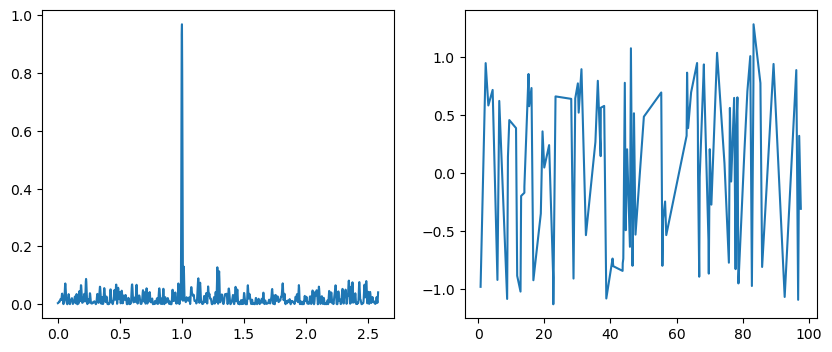

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axes[0].plot(frq, pwr)
axes[1].plot(t, y)
plt.show()

In [59]:
best_frq = frq[np.argmax(pwr)]
t_fit = np.linspace(0, 1)
ls = LombScargle(t, y, 0.1 * (1 + rand.random(100)))
y_fit = ls.model(t_fit, best_frq)

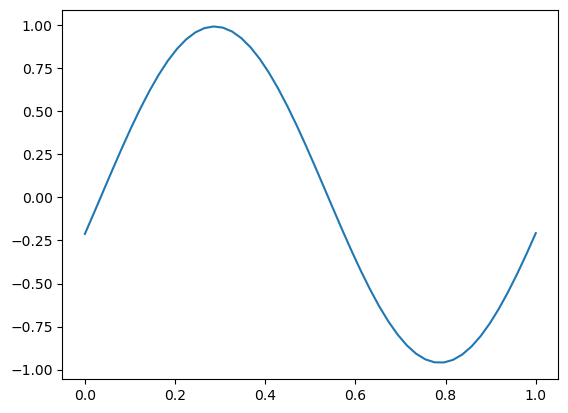

In [60]:
plt.plot(t_fit, y_fit)
plt.show()

In [61]:
print(ls.false_alarm_probability(pwr.max()))

3.3207821610975263e-69

In [62]:
# very insignifcant number = very good chance